In [1]:
import numpy as np

data loading

In [3]:
x_train=np.load("x_train.npy")
y_train=np.load("y_train.npy")

In [5]:
x_val=np.load("x_val.npy")
y_val=np.load("y_val.npy")

In [7]:
y_train=y_train.astype("float32")

model training 

In [15]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten,Dropout
from keras.callbacks import EarlyStopping, LearningRateScheduler


def scheduler(epoch, lr):
    if epoch > 2:
        return lr * 0.03  # Reduce learning rate by 10% after the 2nd epoch
    return lr


# Load ResNet50 pretrained on ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model (initial training)
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers
model_resnet = Sequential([
    base_model,
    Flatten(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(4, activation='softmax')  # Assuming 3 classes
])

early_stop = EarlyStopping(monitor='val_accuracy', patience=1, restore_best_weights=True)
lr_schedule = LearningRateScheduler(scheduler)
# Compile the model
model_resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
model_resnet.fit(
    x_train,
    y_train,
    epochs=10,  # Increased epochs for better learning, paired with early stopping
    batch_size=32,  # Kept the batch size as it is
    validation_data=(x_val, y_val),  # Adding validation data to monitor overfitting
    callbacks=[early_stop, lr_schedule],  # Added callbacks for early stopping and learning rate scheduling
    verbose=1  # To display the training process
)

Epoch 1/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 229s 880ms/step - accuracy: 0.5398 - loss: 3.8976 - val_accuracy: 0.9390 - val_loss: 0.2903 - learning_rate: 0.0010
Epoch 2/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 125s 813ms/step - accuracy: 0.9429 - loss: 0.2483 - val_accuracy: 0.9268 - val_loss: 0.2270 - learning_rate: 0.0010


In [23]:
x_test=np.load("x_test.npy")
y_test=np.load("y_test.npy")

model evaluation

In [43]:
model_resnet.evaluate(x_test,y_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 664ms/step - accuracy: 0.9255 - loss: 0.2842


[0.2812860310077667, 0.9329268336296082]

In [25]:
# Replace x_train and y_train with validation/test data
y_true = y_test  # Ground truth labels for the test set
y_pred_prob = model_resnet.predict(x_test)  # Predicted probabilities for the test set
print(y_pred_prob)
# Ensure y_true is one-hot encoded for multi-class evaluation
from sklearn.preprocessing import label_binarize
classes = [0,1,2,3]  # Extract unique classes from y_true
print(classes)
y_true_binarized = label_binarize(y_true, classes=classes)


16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 789ms/step
[[0.20409013 0.10711347 0.07815106 0.61064535]
 [0.07139907 0.08728372 0.10024615 0.7410711 ]
 [0.01053457 0.0029082  0.05269345 0.9338638 ]
 ...
 [0.05357194 0.08489855 0.04927507 0.8122544 ]
 [0.00949987 0.00557382 0.9760528  0.00887349]
 [0.02159931 0.01538848 0.94443077 0.01858141]]
[0, 1, 2, 3]


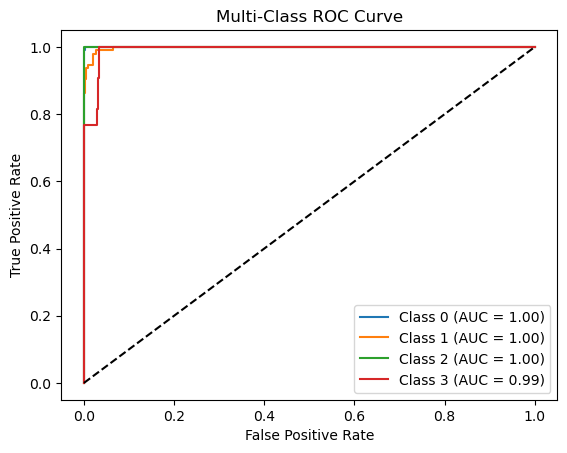

In [27]:
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Assuming y_true contains class indices (e.g., [0, 1, 2]) and y_pred_prob contains predicted probabilities
classes = [0,1,2,3]
y_true_binarized = label_binarize(y_true, classes=classes)  # One-hot encode y_true for multi-class
n_classes = len(classes)

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for all classes
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# Plot settings
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc='best')
plt.show()

In [55]:
import cv2## testing the video clip
from keras.preprocessing.image import img_to_array,load_img
from keras.models import load_model
import numpy as np
video_path = r"C:\Users\kumar\Downloads\test40.mov"
vid = cv2.VideoCapture(video_path)
a=load_model(r"Deep_learning_3cat_adam.h5")
name=["Burglary","Normal","Shoplifiting","Vandalism"]

while(True):
    ret, frame = vid.read()
    frame=cv2.resize(frame,(224,224))
    array=img_to_array(frame)
    print(np.shape(array))
    array=array.reshape(1,224,224,3)
    xdata=np.array(array)
    xdata=xdata.astype("float32")
    xdata=xdata/255.0
    y=model_resnet.predict(xdata)

    text=name[np.argmax(y[0])]
    font = cv2.FONT_HERSHEY_SIMPLEX
    org = (50, 50)
    fontScale = 1
    color = (255, 0, 0)
    thickness = 2
    frame = cv2.putText(frame, text, org, font,fontScale, color, thickness, cv2.LINE_AA)
    cv2.imshow('frame', frame)
    print(text)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
vid.release()
cv2.destroyAllWindows()

(224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
Burglary
(224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Burglary
(224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Burglary
(224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Burglary
(224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Burglary
(224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Burglary
(224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Burglary
(224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Burglary
(224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Burglary
(224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Burglary
(224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Burglary
(224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Normal
(224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Burglary
(224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Burglary
(224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Burglary
(224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Burglary
(224, 224, 3)
1/1 ━━━━━━━━

In [47]:
model_resnet.save("model_resnet.h5")

In [51]:
from sklearn.metrics import precision_score, recall_score, f1_score

y_pred=(model_resnet.predict(x_test)> 0.5).astype(int)
# Example
precision = precision_score(y_test, y_pred, average='macro')  # Change 'macro' to 'weighted' or 'micro' as needed
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Precision (Macro): {precision}")
print(f"Recall (Macro): {recall}")
print(f"F1 Score (Macro): {f1}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 695ms/step
Precision (Macro): 0.9985207100591715
Recall (Macro): 0.8822787079021819
F1 Score (Macro): 0.931995134793059


In [57]:
model_resnet.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │      12,845,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 62,124,814 (236.99 MB)

 Trainable params: 12,845,700 (49.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 25,691,402 (98.00 MB)